In [1]:
import matplotlib
%matplotlib nbagg

import tdms
import imp
imp.reload(tdms)
import plot
import functions
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Steady-state and tail current-Voltage relationship (I-V)

In [2]:
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/D2-vc-060717-vc2-1.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1701-9VCLAMPNACURRENT.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1702-1.tdms")
data = tdms.read_tdms("C:\\Users\\course\\Desktop\\Mantis64\\Lab6_Ca_IV-default-0-351629689.tdms")

In [6]:
holding = -80
pulsedelay = 50
pulsedur = 100
erev = 40
leakcorrection = True
print(data['dt'])

0.04


<IPython.core.display.Javascript object>


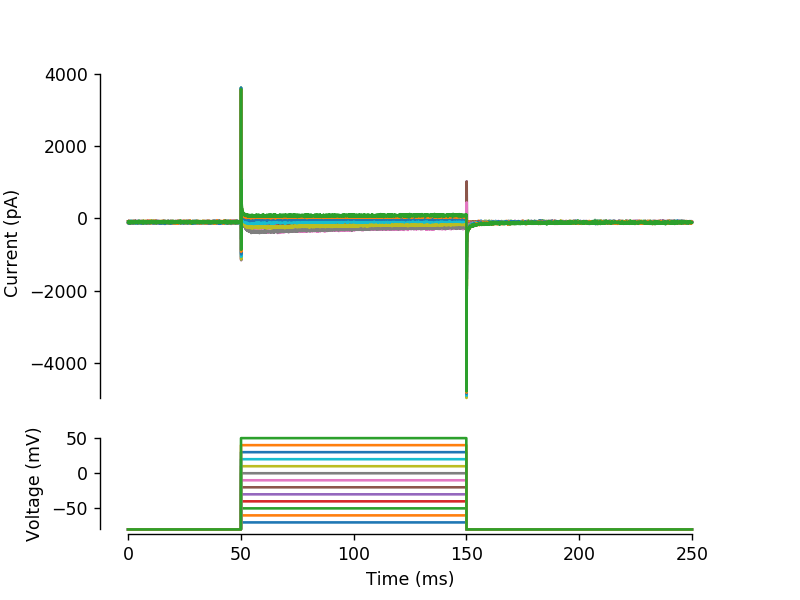

<IPython.core.display.Javascript object>


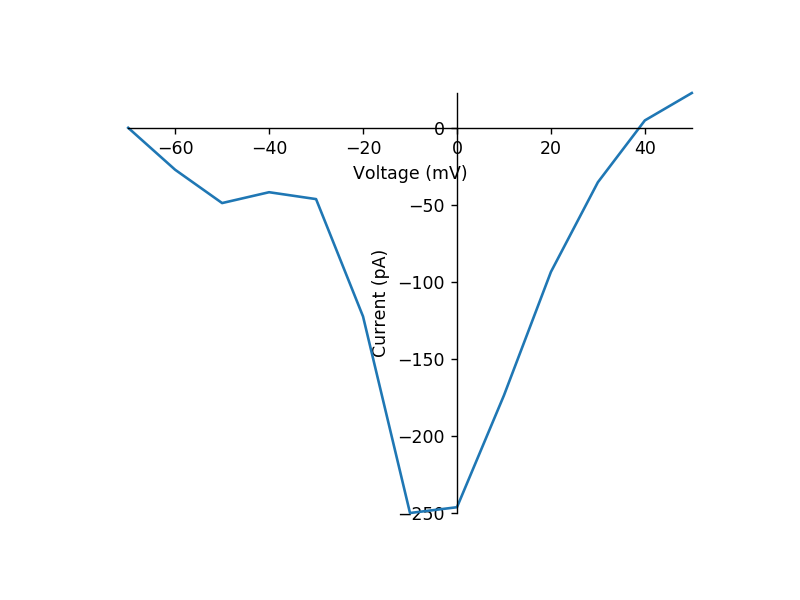

<IPython.core.display.Javascript object>


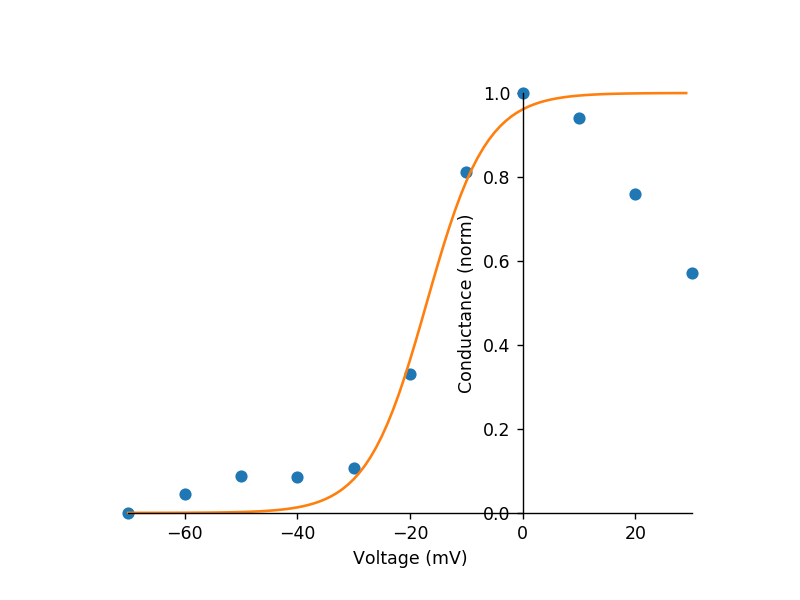

<IPython.core.display.Javascript object>


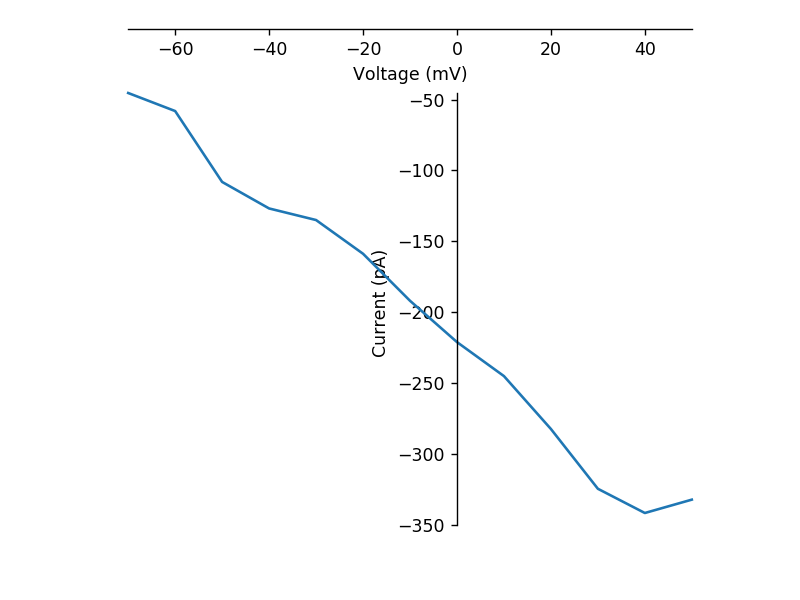

<IPython.core.display.Javascript object>


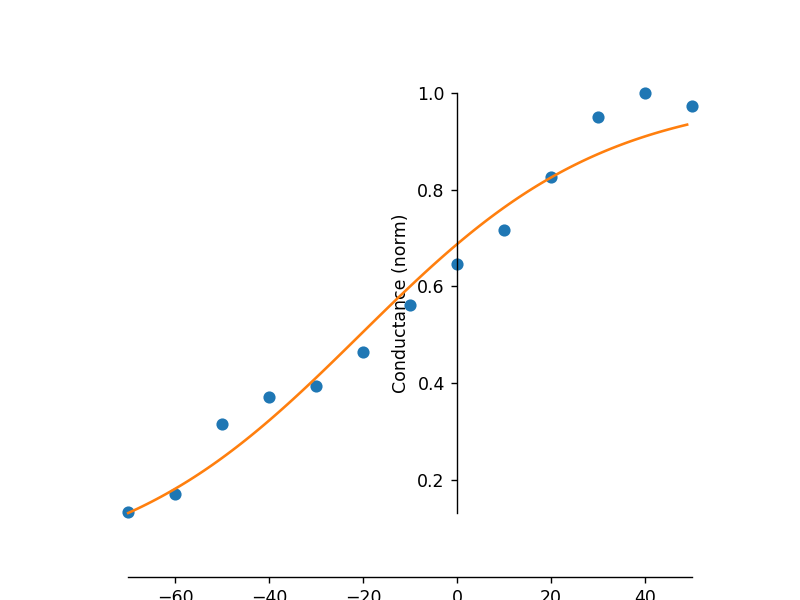

In [9]:
fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
tails = []
steady = []
dt = data['dt']
for sweep, command in zip(data['AI0'], data['AO0']): 
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command[:int((pulsedelay+pulsedur)/dt)]-pulsebase)
    pulsemin = np.min(command[:int((pulsedelay+pulsedur)/dt)]-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax+holding
    else:
        pulseamp = pulsemin+holding
    pulses.append(pulseamp)

    baseline = np.mean(sweep[:int(pulsedelay/dt)])
    rleak = holding / baseline
    ileak = pulseamp / rleak
    tailbaseline = np.mean(sweep[int(-5/dt):])
    maxpeak = np.max(
        sweep[
            int((pulsedelay+pulsedur+0.5)/dt):
            int((pulsedelay+pulsedur+3.0)/dt)]-tailbaseline)
    minpeak = np.min(
        sweep[
            int((pulsedelay+pulsedur+0.5)/dt):
            int((pulsedelay+pulsedur+3.0)/dt)]-tailbaseline)
    # if np.abs(minpeak) > np.abs(maxpeak):
    tails.append(minpeak)
    # else:
    #     peaks.append(maxpeak)
    isteady = np.mean(sweep[
        int((pulsedelay+pulsedur-10)/dt):int((pulsedelay+pulsedur)/dt)])
    if leakcorrection:
        isteady -= ileak
    else:
        isteady -= baseline
    steady.append(isteady)
        
    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)

steady = np.array(steady)
pulses = np.array(pulses)

# Steady-state
fig, ax = plot.plot_iv()
ax.plot(pulses, steady)

g, gfit = functions.gv(steady[pulses<erev], pulses[pulses<erev], erev)
curverange = np.arange(np.min(pulses[pulses<erev]), np.max(pulses[pulses<erev]), 1.0)
curve = functions.fboltz_up(gfit, curverange)

fig, ax = plot.plot_iv(ylabel="Conductance (norm)")
ax.plot(pulses[pulses<erev], g, 'o')
ax.plot(curverange, curve)


# Tail current
fig, ax = plot.plot_iv()
ax.plot(pulses, tails)

g, gfit = functions.gv(np.array(tails), np.array(pulses), np.array(pulses)+erev-holding)
curverange = np.arange(np.min(pulses), np.max(pulses), 1.0)
curve = functions.fboltz_up(gfit, curverange)

fig, ax = plot.plot_iv(ylabel="Conductance (norm)")
ax.plot(pulses, g, 'o')
ax.plot(curverange, curve)


plt.show()

# Deactivation time constant

In [13]:
data = tdms.read_tdms("C:\\Users\\course\\Desktop\\Mantis64\\20180612 - Ca2+ currents in DRG neurons\DRG 3\\Lab7-2-drg32-0-278531427.tdms")

In [22]:
holding = -80
pulsedelay = 10
pulsedur = 100
fitstart = pulsedelay + pulsedur + 2.0
fitend = pulsedelay + pulsedur + 30.0
print(data['dt'])

0.04


<IPython.core.display.Javascript object>


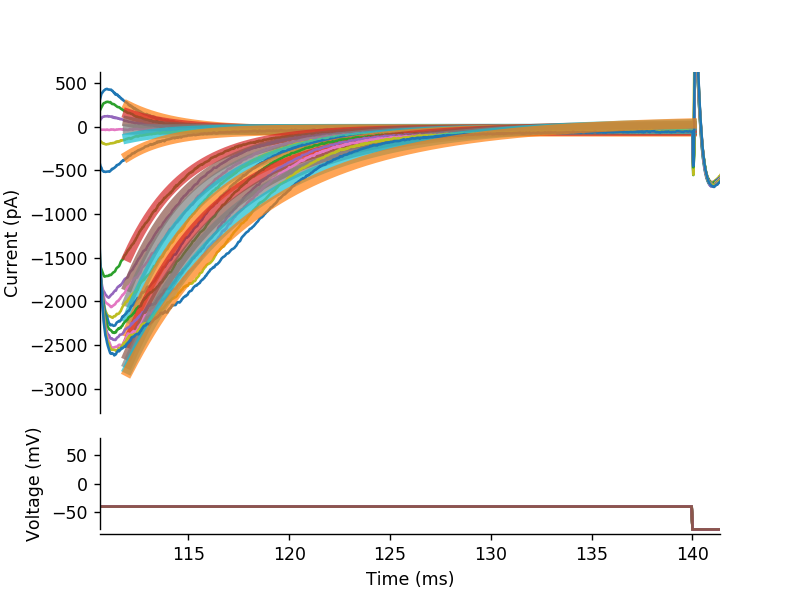

<IPython.core.display.Javascript object>


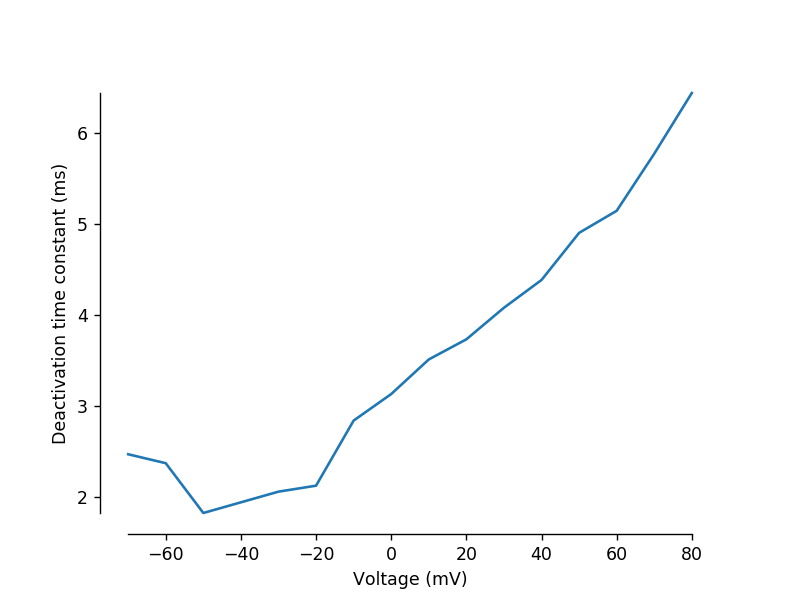

In [24]:
dt = data['dt']

ifitstart = int(fitstart/dt)
ifitend = int(fitend/dt)

fig, axi, axv = plot.plot_traces(mode='vclamp')

pulses = []
taus = []
for sweep, command in zip(data['AI0'], data['AO0']): 
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command[
        int((pulsedelay+pulsedur-10.0)/dt):
        int((pulsedelay+pulsedur-5.0)/dt)]-pulsebase)
    pulsemin = np.min(command[
        int((pulsedelay+pulsedur-10.0)/dt):
        int((pulsedelay+pulsedur-5.0)/dt)]-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax+holding
    else:
        pulseamp = pulsemin+holding

    sweepfit = sweep[ifitstart:ifitend]
    fitrange = np.arange(sweepfit.shape[0]) * dt
    if sweepfit[0] > sweepfit[-1]:
        init_amp = -10.0
    else:
        init_amp = 10.0
    taufit = functions.leastsq(
        functions.leastsq_helper, (sweepfit[-1]-sweepfit[0], 10.0, 0),
        args=(sweepfit, functions.fexp, fitrange))[0]
    plottau = functions.fexp(taufit, fitrange)
    if np.abs(taufit[1]) < 20.0:
        pulses.append(pulseamp)
        taus.append(taufit[1])

    times = np.arange(sweep.shape[0])*data['dt']
    axi.plot(times, sweep)
    axv.plot(times, holding + command)
    axi.plot(fitrange+(ifitstart*dt), plottau, alpha=0.7, lw=6)

fig, ax = plot.plot_iv(ylabel=r"Deactivation time constant (ms)", zeroori=False)
ax.plot(pulses, taus)

# Frequency-current relationship (f-I)

In [34]:
data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-default-7.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1701-8ICLAMPSPIKES.tdms")
# data = tdms.read_tdms("/Volumes/DATA/data/tdms/CHSL-6.8.1702iclamp-1.tdms")

In [38]:
pulsedelay = 200.0
pulsedur = 400.0
threshold = -10.0

<IPython.core.display.Javascript object>


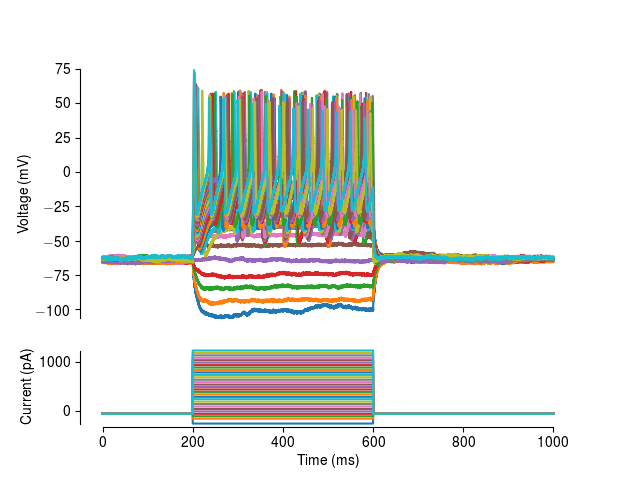

<IPython.core.display.Javascript object>


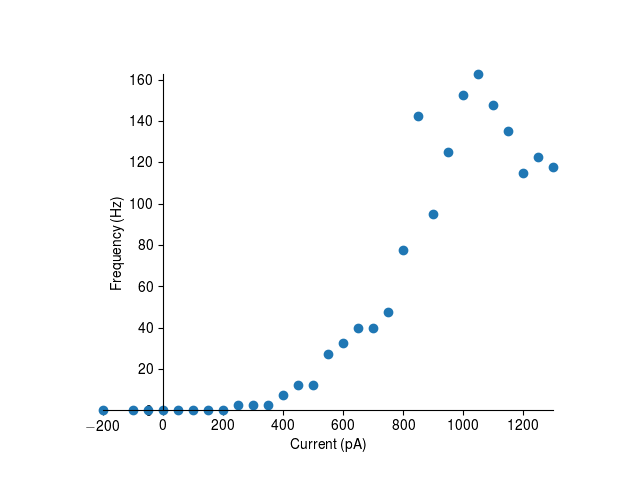

In [39]:
fig, axv, axi = plot.plot_traces(mode='cclamp')

pulses = []
fs = []
steady = []
dt = data['dt']
for sweep, command in zip(data['AI0'], data['A00']):
    pulsebase = np.mean(command[:int(pulsedelay/dt)])
    pulsemax = np.max(command-pulsebase)
    pulsemin = np.min(command-pulsebase)
    if np.abs(pulsemax) > np.abs(pulsemin):
        pulseamp = pulsemax
    else:
        pulseamp = pulsemin
    pulses.append(pulseamp)
    
    crossings = np.where(np.diff((sweep > threshold).astype(np.float)) == 1.0)[0]
    fs.append(1e3*len(crossings)/pulsedur)
    times = np.arange(sweep.shape[0])*data['dt']
    axv.plot(times, sweep)
    axi.plot(times, holding + command)

fig, ax = plot.plot_fi()
ax.plot(pulses, fs, 'o')
# ax.plot(pulses, steady)
plt.show()

In [16]:
from nptdms import TdmsFile

In [17]:
tdms_file = TdmsFile("/Volumes/DATA/data/tdms/CHSL-6.8.1701-9VCLAMPNACURRENT.tdms")

In [18]:
tdms_file.groups()

[u'AO0', u'AI0']

In [19]:
tdms_file.object().properties['Sampling Rate(AI)']

u'25000'

In [20]:
1.0/25000

4e-05

In [5]:
print(gfit)

[ 3.03668121  8.70758923]
